# BinConv Training Example

This notebook demonstrates how to train a BinConv model on synthetic data with linear trend and Gaussian noise using only existing functions.

In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

from binconvfm.models.binconv import LightningBinConv
from pytorch_lightning import Trainer

## Generate Linear Trend + Gaussian Noise Data

Generated training data shape: (1000, 65)


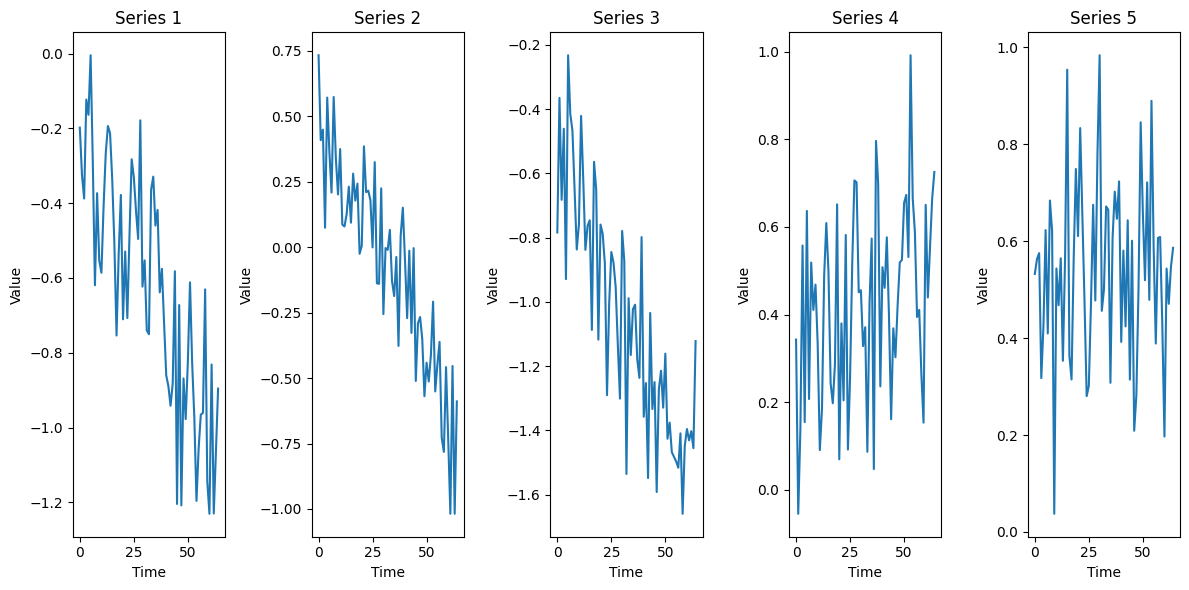

In [2]:
def generate_linear_trend_data(num_samples, seq_length, noise_std=0.1):
    """
    Generate time series with linear trends and Gaussian noise.
    
    Args:
        num_samples: Number of time series to generate
        seq_length: Length of each time series
        noise_std: Standard deviation of Gaussian noise
    
    Returns:
        numpy array of shape (num_samples, seq_length)
    """
    data = []
    
    for i in range(num_samples):
        # Random slope and intercept for linear trend
        slope = np.random.uniform(-0.02, 0.02)  # Small slopes for realistic trends
        intercept = np.random.uniform(-1, 1)
        
        # Time points
        t = np.arange(seq_length)
        
        # Linear trend
        trend = slope * t + intercept
        
        # Add Gaussian noise
        noise = np.random.normal(0, noise_std, seq_length)
        
        # Combine trend and noise
        series = trend + noise
        data.append(series)
    
    return np.array(data)

# Generate training data
context_length = 64
prediction_length = 1  # BinConv predicts one step ahead
num_train_samples = 1000
noise_std = 0.2

# Generate raw data
train_data = generate_linear_trend_data(num_train_samples, context_length + prediction_length, noise_std)
print(f"Generated training data shape: {train_data.shape}")

# Plot a few examples
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.plot(train_data[i])
    plt.title(f'Series {i+1}')
    plt.xlabel('Time')
    plt.ylabel('Value')
plt.tight_layout()
plt.show()

## Create Dataset for BinConv Training

In [3]:
class LinearTrendDataset(Dataset):
    """
    Dataset for BinConv training with linear trend + noise data.
    
    Returns (input_sequence, target_value) pairs where:
    - input_sequence: context_length time steps 
    - target_value: next single time step
    """
    
    def __init__(self, data, context_length):
        self.data = torch.FloatTensor(data)
        self.context_length = context_length
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # Input: first context_length points
        input_seq = self.data[idx, :self.context_length].unsqueeze(-1)  # Add feature dim
        
        # Target: next single point
        target = self.data[idx, self.context_length:self.context_length+1].unsqueeze(-1)
        
        return input_seq, target

# Create datasets
train_dataset = LinearTrendDataset(train_data, context_length)

# Create validation data (smaller set)
val_data = generate_linear_trend_data(200, context_length + prediction_length, noise_std)
val_dataset = LinearTrendDataset(val_data, context_length)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

# Check data shapes
sample_input, sample_target = train_dataset[0]
print(f"Sample input shape: {sample_input.shape}")
print(f"Sample target shape: {sample_target.shape}")

Training dataset size: 1000
Validation dataset size: 200
Sample input shape: torch.Size([64, 1])
Sample target shape: torch.Size([1, 1])


## Initialize BinConv Model

In [4]:
# Model hyperparameters
num_bins = 128  # Number of quantization bins
min_bin_value = -3.0  # Based on expected data range after scaling
max_bin_value = 3.0
num_filters_2d = 16
num_filters_1d = 16
num_blocks = 2
learning_rate = 1e-3

# Initialize the LightningBinConv model
model = LightningBinConv(
    context_length=context_length,
    is_prob_forecast=True,  # Enable probabilistic forecasting
    num_bins=num_bins,
    min_bin_value=min_bin_value,
    max_bin_value=max_bin_value,
    num_filters_2d=num_filters_2d,
    num_filters_1d=num_filters_1d,
    num_blocks=num_blocks,
    prediction_length=prediction_length,
    target_dim=1,
    scaler_type='standard',  # Use standard scaling
    lr=learning_rate
)

print(f"Model initialized with {sum(p.numel() for p in model.parameters())} parameters")
print(f"Context length: {context_length}")
print(f"Number of bins: {num_bins}")
print(f"Scaler type: standard")

Model initialized with 10213 parameters
Context length: 64
Number of bins: 128
Scaler type: standard


In [ ]:
# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize trainer
trainer = Trainer(
    max_epochs=20,
    accelerator='cpu',  # Change to 'gpu' if CUDA is available
    enable_progress_bar=True,
    log_every_n_steps=10
)

# Train the model
print("Starting training...")
trainer.fit(model, train_loader, val_loader)
print("Training completed!")

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/andreichernov/Documents/Personal/research/AIFM/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/andreichernov/Documents/Personal/research/AIFM/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages ar

Starting training...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/andreichernov/Documents/Personal/research/AIFM/venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
Standard deviation is zero, setting to 1.0 to avoid division by zero
Standard deviation is zero, setting to 1.0 to avoid division by zero
Standard deviation is zero, setting to 1.0 to avoid division by zero
Standard deviation is zero, setting to 1.0 to avoid division by zero
Standard deviation is zero, setting to 1.0 to avoid division by zero
Standard deviation is zero, setting to 1.0 to avoid division by zero
Standard deviation is zero, setting to 1.0 to avoid division by zero
Standard deviation is zero, setting to 1.0 to avoid division by zero
Standard deviation is zero, setting to 1.0 to avoid division by zero
Standard deviation is zero, sett

Training: |          | 0/? [00:00<?, ?it/s]

Standard deviation is zero, setting to 1.0 to avoid division by zero
Standard deviation is zero, setting to 1.0 to avoid division by zero
Standard deviation is zero, setting to 1.0 to avoid division by zero
Standard deviation is zero, setting to 1.0 to avoid division by zero
Standard deviation is zero, setting to 1.0 to avoid division by zero
Standard deviation is zero, setting to 1.0 to avoid division by zero
Standard deviation is zero, setting to 1.0 to avoid division by zero
Standard deviation is zero, setting to 1.0 to avoid division by zero
Standard deviation is zero, setting to 1.0 to avoid division by zero
Standard deviation is zero, setting to 1.0 to avoid division by zero
Standard deviation is zero, setting to 1.0 to avoid division by zero
Standard deviation is zero, setting to 1.0 to avoid division by zero
Standard deviation is zero, setting to 1.0 to avoid division by zero
Standard deviation is zero, setting to 1.0 to avoid division by zero
Standard deviation is zero, settin

Validation: |          | 0/? [00:00<?, ?it/s]

Standard deviation is zero, setting to 1.0 to avoid division by zero
Standard deviation is zero, setting to 1.0 to avoid division by zero
Standard deviation is zero, setting to 1.0 to avoid division by zero
Standard deviation is zero, setting to 1.0 to avoid division by zero
Standard deviation is zero, setting to 1.0 to avoid division by zero
Standard deviation is zero, setting to 1.0 to avoid division by zero
Standard deviation is zero, setting to 1.0 to avoid division by zero
Standard deviation is zero, setting to 1.0 to avoid division by zero
Standard deviation is zero, setting to 1.0 to avoid division by zero
Standard deviation is zero, setting to 1.0 to avoid division by zero
Standard deviation is zero, setting to 1.0 to avoid division by zero
Standard deviation is zero, setting to 1.0 to avoid division by zero
Standard deviation is zero, setting to 1.0 to avoid division by zero
Standard deviation is zero, setting to 1.0 to avoid division by zero
Standard deviation is zero, settin

## Test Forecasting

In [ ]:
# Generate test data
test_data = generate_linear_trend_data(5, context_length + 10, noise_std)  # Longer for visualization
test_inputs = torch.FloatTensor(test_data[:, :context_length]).unsqueeze(-1)  # (5, context_length, 1)

print(f"Test input shape: {test_inputs.shape}")

# Make predictions
model.eval()
with torch.no_grad():
    # Use the forecast method for multi-step prediction
    forecasts = model.forecast(test_inputs, num_samples=1)  # Single sample prediction
    print(f"Forecast shape: {forecasts.shape}")

# Visualize results
plt.figure(figsize=(15, 10))
for i in range(5):
    plt.subplot(2, 3, i+1)
    
    # Original context
    context = test_data[i, :context_length]
    true_future = test_data[i, context_length:context_length+5]  # Next 5 points
    
    # Plot context (known data)
    plt.plot(range(context_length), context, 'b-', label='Context', linewidth=2)
    
    # Plot true future
    future_x = range(context_length, context_length + len(true_future))
    plt.plot(future_x, true_future, 'g-', label='True Future', linewidth=2)
    
    # Plot prediction (first step)
    if forecasts.dim() >= 4:  # Handle different forecast shapes
        pred_val = forecasts[i, 0, 0, 0].item()  # Get first prediction
    else:
        pred_val = forecasts[i].flatten()[0].item()
    
    plt.plot([context_length], [pred_val], 'ro', label='BinConv Prediction', markersize=8)
    
    plt.title(f'Test Series {i+1}')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\\n🎉 BinConv Training and Testing Complete!")
print("   The model has learned to predict linear trends with Gaussian noise.")